In [ ]:
import os
import sqlite3
import pandas as pd
import requests
import numpy as np
import io

# ===============================
# CONFIG
# ===============================
DB_FILE = "exoplanets.db"
TABLE_NAME = "pscomppars"
TAP_URL = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
ADQL_QUERY = f"SELECT * FROM {TABLE_NAME}"


# ===============================
# STEP 1. Download data from Exoplanet Archive
# ===============================
def download_table(
    adql_query: str = ADQL_QUERY, download_full: bool = True
) -> pd.DataFrame:
    """Download a table from the NASA Exoplanet Archive TAP service into a DataFrame."""
    print("Downloading table from Exoplanet Archive...")
    response = requests.get(
        TAP_URL, params={"query": adql_query, "format": "csv"}, timeout=120
    )
    response.raise_for_status()  # raise error if request failed
    df = pd.read_csv(io.StringIO(response.text))
    if download_full:
        df.to_csv("full_exoplanet_archive.csv", index=False)
        print(f"Downloaded {len(df)} rows and {len(df.columns)} columns.")
    else:
        print(f"Loaded {len(df)} rows and {len(df.columns)} columns.")
    return df


# ===============================
# STEP 2. Save DataFrame to SQLite
# ===============================
def save_to_sqlite(
    df: pd.DataFrame, db_file: str = DB_FILE, table_name: str = TABLE_NAME
):
    """Save DataFrame into an SQLite database."""
    conn = sqlite3.connect(db_file)
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.close()
    print(f"Saved table '{table_name}' to {db_file}")


# ===============================
# STEP 3. Open/close connections
# ===============================
def get_connection(db_file: str = DB_FILE):
    """Get a SQLite connection object."""
    return sqlite3.connect(db_file)


def close_connection(conn, cursor=None):
    """Close cursor and connection safely."""
    if cursor is not None:
        cursor.close()
    conn.close()


# ===============================
# STEP 4. Run SQL queries
# ===============================
def run_query(query: str, db_file: str = DB_FILE):
    """Run an SQL query and return results as a list of tuples."""
    conn = get_connection(db_file)
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    close_connection(conn, cur)
    return rows


def ensure_database(update: bool = True):
    """
    Ensure database is ready.
    If update=True, always download the latest version and overwrite.
    If update=False, only download if database does not exist.
    """
    if update or not os.path.exists(DB_FILE):
        if update:
            print("Updating local database with latest Exoplanet Archive data...")
        else:
            print("Database not found. Creating it...")
        global exopl_db
        exopl_db = download_table()
        save_to_sqlite(exopl_db)
    else:
        print("Database already exists. Skipping download.")
    print("You can manipulate the pandas DataFrame called 'exopl_db' directly.")
    return exopl_db


# ===============================
# USAGE EXAMPLE
# ===============================
if __name__ == "__main__":
    # Step A: ensure database is ready
    ensure_database(update=True)

    # Step B: run a query
    example_query = f"""
    SELECT pl_name, hostname, pl_rade, pl_masse
    FROM {TABLE_NAME}
    WHERE pl_massj < 1
    ORDER BY pl_massj
    LIMIT 10000;
    """
    results = run_query(example_query)
    # for row in results:
    #     print(row)

## Check here for details of table collumns names and parameters

[https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html#columns](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html#columns)

/tmp/ipykernel_2923638/1898686894.py:206: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=11, weight="bold")
/tmp/ipykernel_2923638/1898686894.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=11, weight="bold")


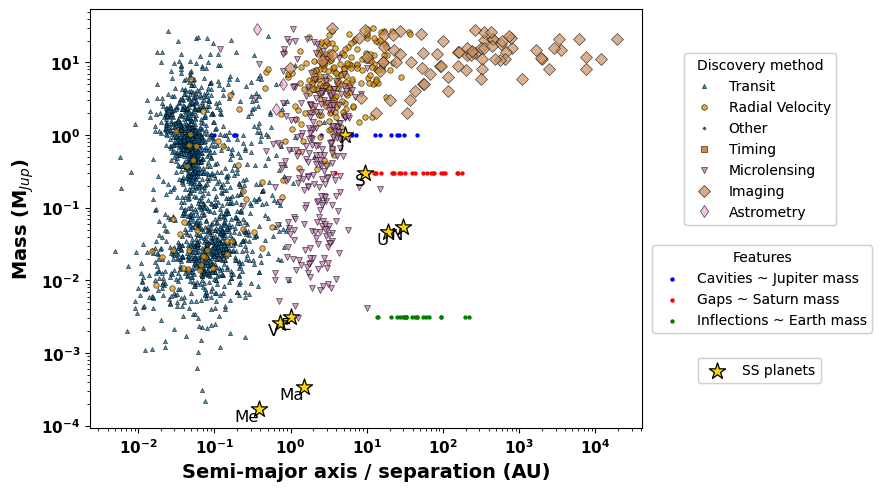

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

exopl_db = pd.read_csv("full_exoplanet_archive.csv", header=0)

feat_table = pd.read_csv(
    "../src/bhowmik2025_et_al_plots/input_files/gap_ring_infl_pt.csv", header=0
)


# print([s for s in exopl_db.columns if "dis" in s])
def custom_log_formatter(x, pos):
    # x is the value on the log scale, convert it back to original scale
    return f"{10**(x):.0f}"


fig, ax = plt.subplots(constrained_layout=True)  # , figsize=(10, 6))
# Get unique discovery methods and assign a color to each

discovery_methods = exopl_db["discoverymethod"].astype(str).fillna("Unknown")
unique_methods = discovery_methods.unique()
opt_methods = []

for i in range(len(exopl_db)):
    if "Timing" in exopl_db["discoverymethod"][i]:
        opt_methods.append("Timing")
    elif "Radial Velocity" in exopl_db["discoverymethod"][i]:
        opt_methods.append("Radial Velocity")
    elif "Transit" in exopl_db["discoverymethod"][i]:
        opt_methods.append("Transit")
    elif "Imaging" in exopl_db["discoverymethod"][i]:
        opt_methods.append("Imaging")
    elif "Astrometry" in exopl_db["discoverymethod"][i]:
        opt_methods.append("Astrometry")
    elif "Microlensing" in exopl_db["discoverymethod"][i]:
        opt_methods.append("Microlensing")
    else:
        opt_methods.append("Other")

unique_opt_methods = pd.Series(opt_methods).unique()

palette = sns.color_palette("colorblind", n_colors=len(unique_opt_methods))

method_color = dict(zip(unique_opt_methods, palette))
method_marker = {
    "Timing": ["s", 5],  # square
    "Radial Velocity": ["o", 4],  # circle
    "Transit": ["^", 3],  # triangle
    "Imaging": ["D", 6],  # diamond
    "Astrometry": ["d", 6],  # thin diamond
    "Microlensing": ["v", 5],  # upside triangle
    "Other": ["P", 2],  # plus-filled
}

for method in unique_opt_methods:
    mask = (
        discovery_methods == method
    )  # You can set just one method here to check such as "Astrometry"
    ax.plot(
        exopl_db.loc[mask, "pl_orbsmax"],
        exopl_db.loc[mask, "pl_massj"],
        linestyle="None",
        label=method,
        marker=method_marker.get(method, ["o", 2])[0],  # fallback circle
        markersize=method_marker.get(method, ["o", 2])[1],  # fallback size 2
        alpha=0.7,
        markeredgecolor="black",
        markeredgewidth=0.5,
        color=method_color[method],
    )
# Create the first legend (methods)
handles1, labels1 = ax.get_legend_handles_labels()
by_label1 = dict(zip(labels1, handles1))

legend1 = fig.legend(
    by_label1.values(),
    by_label1.keys(),
    bbox_to_anchor=(1.06, 0.9),
    loc="upper left",
    borderaxespad=0.0,
    title="Discovery method",
)
fig.add_artist(legend1)  # Keep this legend when adding the second one

# --- Second scatter: gaps, inflections, cavities ---
gap_feat = feat_table["R"][feat_table["D/B"].astype(str).str.contains("D")]
inf_feat = feat_table["R"][feat_table["D/B"].astype(str).str.contains("I")]
cav_feat = feat_table["R"][feat_table["D/B"].astype(str).str.contains("C")]

ax.scatter(
    cav_feat,
    [1] * len(cav_feat),
    marker=".",
    color="blue",
    linewidth=0.1,
    label="Cavities ~ Jupiter mass",
)
ax.scatter(
    gap_feat,
    [0.299] * len(gap_feat),
    marker=".",
    color="red",
    linewidth=0.1,
    label="Gaps ~ Saturn mass",
)
ax.scatter(
    inf_feat,
    [0.00315] * len(inf_feat),
    marker=".",
    color="green",
    linewidth=0.1,
    label="Inflections ~ Earth mass",
)

# Create the second legend
handles2, labels2 = ax.get_legend_handles_labels()
# Only keep the last two (the new scatter points)
handles2 = handles2[-3:]
labels2 = labels2[-3:]

legend2 = fig.legend(
    handles2,
    labels2,
    bbox_to_anchor=(1.01, 0.5),  # adjust position for second legend
    loc="upper left",
    borderaxespad=0.0,
    title="Features",
)
fig.add_artist(legend2)

# Solar system planets

solar_system_planets = {
    "Mercury": [0.39, 0.00017],
    "Venus": [0.72, 0.00257],
    "Earth": [1.00, 0.00315],
    "Mars": [1.52, 0.00034],
    "Jupiter": [5.20, 1.00],
    "Saturn": [9.58, 0.30],
    "Uranus": [19.18, 0.046],
    "Neptune": [30.07, 0.054],
}

# planet_symbols = {
#     "Mercury": "☿",
#     "Venus": "♀",
#     "Earth": "⊕",
#     "Mars": "♂",
#     "Jupiter": "♃",
#     "Saturn": "♄",
#     "Uranus": "♅",
#     "Neptune": "♆"
# }
planet_symbols = {
    "Mercury": "Me",
    "Venus": "V",
    "Earth": "E",
    "Mars": "Ma",
    "Jupiter": "J",
    "Saturn": "S",
    "Uranus": "U",
    "Neptune": "N",
}

for planet, (a, m) in solar_system_planets.items():
    ax.text(
        a,
        m,
        planet_symbols[planet],
        ha="right",
        va="top",
        fontsize=12,
        color="black",
    )

for planet, (a, m) in solar_system_planets.items():
    ax.scatter(
        a,
        m,
        marker="*",  # star symbol
        s=150,  # size (points^2)
        color="gold",  # fill color
        edgecolor="black",
        linewidth=0.9,
        label="SS planets",
    )

# Handles/labels for Solar System planets
handles_ss, labels_ss = ax.get_legend_handles_labels()
handles_ss = handles_ss[-1:]
labels_ss = labels_ss[-1:]

legend_ss = fig.legend(
    handles_ss,
    labels_ss,
    bbox_to_anchor=(1.07, 0.28),
    loc="upper left"
)
fig.add_artist(legend_ss)
# --- Axes settings ---

ax.set_xlabel("Semi-major axis / separation (AU)", fontsize=14, weight="bold")
ax.set_ylabel(r"Mass (M$_{Jup}$)", fontsize=14, weight="bold")
ax.set_xticklabels(ax.get_xticks(), fontsize=11, weight="bold")
ax.set_yticklabels(ax.get_yticks(), fontsize=11, weight="bold")
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_facecolor("darkgrey")
plt.savefig("demog_plot.png",dpi=600)
plt.savefig("demog_plot.pdf",dpi=600)# , bbox_inches="tight")

# plt.tight_layout()

# ax.xaxis.set_major_formatter(custom_log_formatter)
# ax.yaxis.set_major_formatter(custom_log_formatter)
# gaps - saurn mass
# cavities jupiter mass
# inflections - earth mass

In [ ]:
np.max(df["semimaj"])
len(exopl_db["pl_orbsmax"]) / len(gaps_inf)
len(df["semimaj"].dropna())
len(df["gaps_inf"].dropna())

(array([24., 12.,  5.,  2.,  2.,  1.,  0.,  0.,  0.,  0.]),
 array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360., 400.]),
 <BarContainer object of 10 artists>)

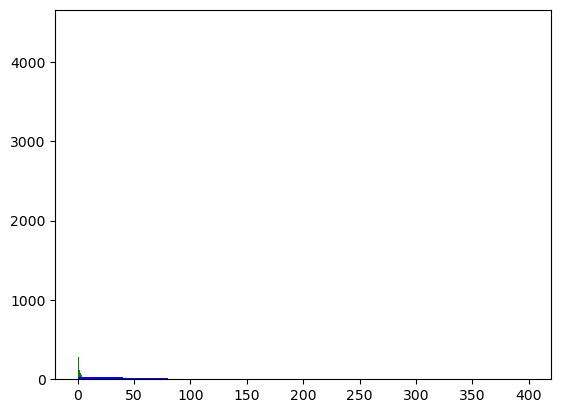

In [ ]:
from matplotlib import colors

gaps_inf = pd.concat([gap_feat, inf_feat], ignore_index=False)
df = pd.DataFrame({"semimaj": exopl_db["pl_orbsmax"], "gaps_inf": gaps_inf})
df_cleaned = df.dropna(subset=["semimaj", "gaps_inf"])
plt.hist(
    df["semimaj"].dropna(), bins=(1000), range=(0, 400), color="green"
)  # ,norm = colors.LogNorm())
plt.hist(
    df["gaps_inf"].dropna(), bins=(10), range=(0, 400), color="blue"
)  # ,norm = colors.LogNorm())

In [ ]:
# df = pd.DataFrame({"semimaj":exopl_db["pl_orbsmax"],"gap":gap_feat,"inf":inf_feat})
# gap_feat+inf_feat
gaps_inf = pd.concat([gap_feat, inf_feat], ignore_index=False)
df = pd.DataFrame({"semimaj": exopl_db["pl_orbsmax"], "gaps_inf": gaps_inf})
# sns.kdeplot(df, x ="semimaj",y="gaps_inf",fill=True,cmap="viridis")
# plt.contourf(df["semimaj"],df["gaps_inf"],levels=14,cmap="viridis")
# sns.kdeplot(df, x ="semimaj",y="inf",fill=False,cmap="viridis")

# sns.kdeplot(df,fill=True,cmap="viridis")

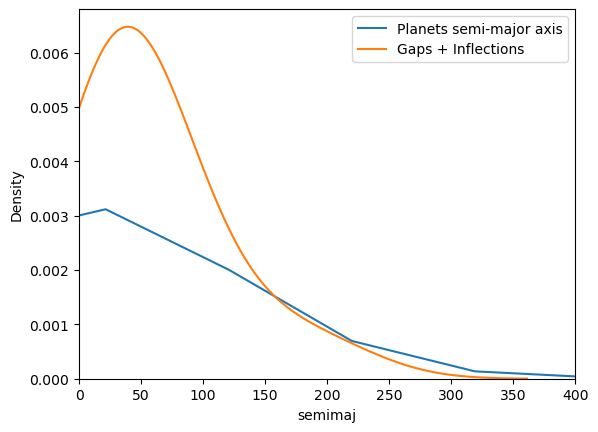

In [ ]:
sns.kdeplot(df["semimaj"], bw_adjust=2, label="Planets semi-major axis")
sns.kdeplot(df["gaps_inf"], bw_adjust=2, label="Gaps + Inflections")
plt.xlim(0, 400)
plt.legend()

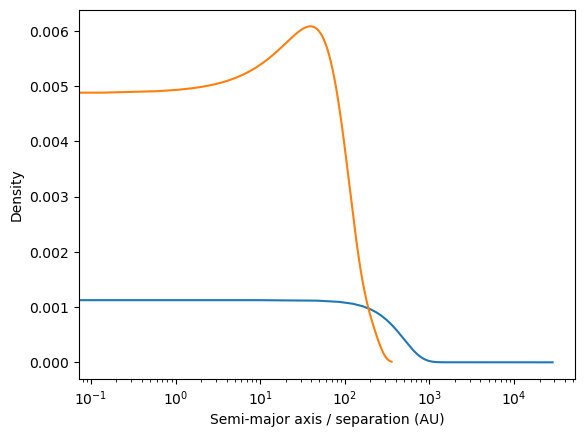

In [ ]:
# df.plot.kde()
#
ax = exopl_db["pl_orbsmax"].plot.kde(bw_method=1)
ax2 = feat_table["R"].plot.kde(bw_method=1)
# ax.xaxis.set_major_formatter(custom_log_formatter)
ax.set_xlabel("Semi-major axis / separation (AU)")
# ax.set_ylim(0, 1)
ax.set_xscale("log")
ax2.set_xscale("log")
ax.set_yscale("linear")


def custom_log_formatter(x, pos):
    # x is the value on the log scale, convert it back to original scale
    return f"{x/np.max(x):.0f}"


# ax.yaxis.set_major_formatter(custom_log_formatter)

<Axes: xlabel='semimaj', ylabel='jup_mass'>

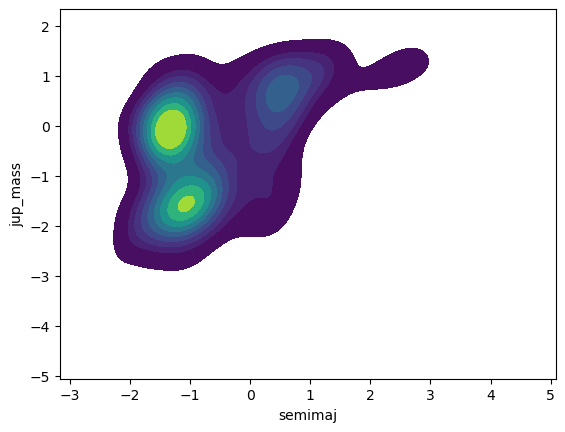

In [ ]:
df = pd.DataFrame(
    {
        "semimaj": np.log10(exopl_db["pl_orbsmax"]),
        "jup_mass": np.log10(exopl_db["pl_massj"]),
    }
)
sns.kdeplot(df, x="semimaj", y="jup_mass", fill=True, cmap="viridis")